In [1]:
## Importando Pacotes
from time import *
tic = time()

import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import warnings
from datetime import *
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, jaccard_score, balanced_accuracy_score, roc_auc_score, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss   

from utils.eda import *
from utils.modelling_tools import *

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
seed = 123

In [2]:
## Carregando dataset
file_path = f'dados/df_cashout_treino_feature_eng.parquet'  

df_raw = pd.read_parquet(file_path)

target =  df_raw['last_status']
transaction_id =  df_raw['transaction_id']
fraud = df_raw['fraud']

transaction_datetime_request, hora, dia, dia_semana = df_raw['transaction_datetime_request'], df_raw['hora'], df_raw['dia'], df_raw['dia_semana'] 

In [3]:
df_raw[df_raw['transaction_payer_registration_data_doc'] == '46201083000188'][['transaction_datetime_request', 'mean_amount_same_doc_in_7D', 'razao_valor_frequencia_7D', 'roc_razao_valor_frequencia_7D']].head(10)

,transaction_datetime_request,mean_amount_same_doc_in_7D,razao_valor_frequencia_7D,roc_razao_valor_frequencia_7D
17627,2024-06-03 19:40:02.392,1700.00,1700.00,0.00
17629,2024-06-03 19:40:15.897,916.00,916.00,-0.46
17696,2024-06-03 19:42:39.024,736.67,736.67,-0.20
17699,2024-06-03 19:42:55.014,802.50,802.50,0.09
17821,2024-06-03 19:43:37.140,662.00,662.00,-0.18
17825,2024-06-03 19:44:24.739,576.67,576.67,-0.13
17826,2024-06-03 19:44:28.810,511.43,511.43,-0.11
17831,2024-06-03 19:44:47.354,470.62,470.62,-0.08
17947,2024-06-03 19:46:30.094,437.78,437.78,-0.07
17948,2024-06-03 19:46:36.860,403.00,403.00,-0.08


In [4]:
target.value_counts()

last_status
APPROVED           10092900
REJECTED              17541
SUSPECTED_FRAUD         255
FRAUD                    49
CONT_FRAUD                3
Name: count, dtype: Int64

In [5]:
numerics = ['int16','int32','int64','float16','float32','float64']
numeric_features = df_raw.select_dtypes(include=numerics).columns

df_raw = df_raw[numeric_features]

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10110748 entries, 0 to 10110747
Data columns (total 35 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   transaction_amount_total             float64
 1   fraud                                float64
 2   hora                                 int32  
 3   dia                                  int32  
 4   dia_semana                           int32  
 5   test_transaction                     int32  
 6   sum_amount_same_doc_in_1H            float64
 7   sum_amount_same_doc_in_7D            float64
 8   sum_amount_same_doc_in_30D           float64
 9   count_amount_same_doc_in_1H          int64  
 10  count_amount_same_doc_in_7D          int64  
 11  count_amount_same_doc_in_30D         int64  
 12  mean_amount_same_doc_in_1H           float64
 13  mean_amount_same_doc_in_7D           float64
 14  mean_amount_same_doc_in_30D          float64
 15  std_amount_in_1H              

In [6]:
df_raw.isna().sum()

transaction_amount_total               0
fraud                                  0
hora                                   0
dia                                    0
dia_semana                             0
test_transaction                       0
sum_amount_same_doc_in_1H              0
sum_amount_same_doc_in_7D              0
sum_amount_same_doc_in_30D             0
count_amount_same_doc_in_1H            0
count_amount_same_doc_in_7D            0
count_amount_same_doc_in_30D           0
mean_amount_same_doc_in_1H             0
mean_amount_same_doc_in_7D             0
mean_amount_same_doc_in_30D            0
std_amount_in_1H                       0
std_amount_in_7D                       0
std_amount_in_30D                      0
amount_7D_1H                           0
amount_30d_7d                          0
behav_increase_7d_1H_amount            0
behav_increase_30d_7d_amount           0
transacoes_unicas_pagador_recebedor    0
recebedores_unicos_por_pagador         0
pagadores_unicos

In [7]:
df_raw.drop(['fraud', 'hora', 'dia', 'dia_semana'], axis='columns', inplace=True)

In [8]:
df = transformed_data_lower_skew(df_raw)
# df = df_raw.copy()

Coluna: transaction_amount_total -> Transformada em: log
Coluna: test_transaction -> Transformada em: x
Coluna: sum_amount_same_doc_in_1H -> Transformada em: log
Coluna: sum_amount_same_doc_in_7D -> Transformada em: log
Coluna: sum_amount_same_doc_in_30D -> Transformada em: log
Coluna: count_amount_same_doc_in_1H -> Transformada em: log
Coluna: count_amount_same_doc_in_7D -> Transformada em: log
Coluna: count_amount_same_doc_in_30D -> Transformada em: log
Coluna: mean_amount_same_doc_in_1H -> Transformada em: pw4
Coluna: mean_amount_same_doc_in_7D -> Transformada em: pw4
Coluna: mean_amount_same_doc_in_30D -> Transformada em: pw4
Coluna: std_amount_in_1H -> Transformada em: log
Coluna: std_amount_in_7D -> Transformada em: log
Coluna: std_amount_in_30D -> Transformada em: log
Coluna: amount_7D_1H -> Transformada em: log
Coluna: amount_30d_7d -> Transformada em: log
Coluna: behav_increase_7d_1H_amount -> Transformada em: log
Coluna: behav_increase_30d_7d_amount -> Transformada em: sqrt
C

In [9]:
## Dimensionando a Matriz
num_plots = len(numeric_features)

## Definindo o tamanho da matriz dos histogramas e outliers
ncols = 3
nrows = int(np.ceil(num_plots/ncols))

num_plots, ncols, nrows

(35, 3, 12)

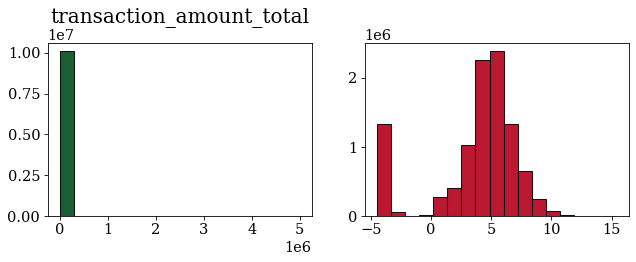

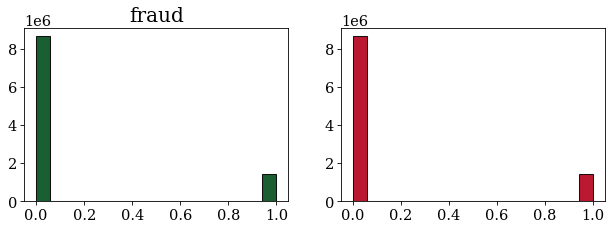

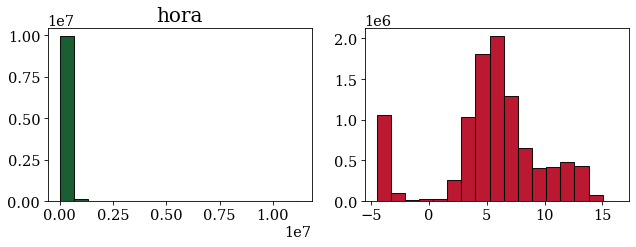

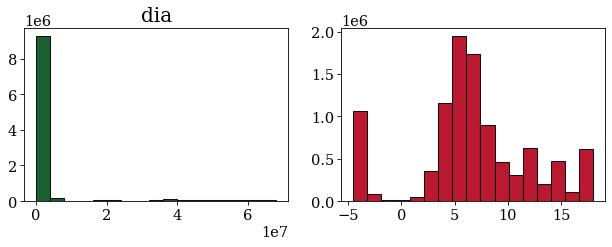

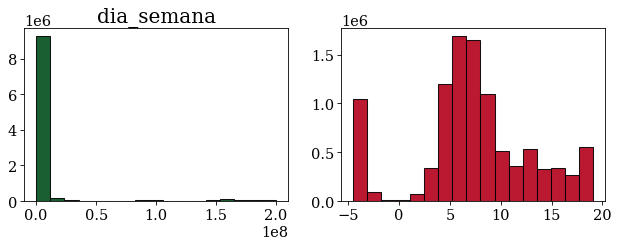

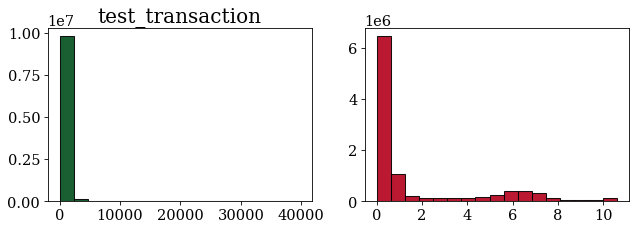

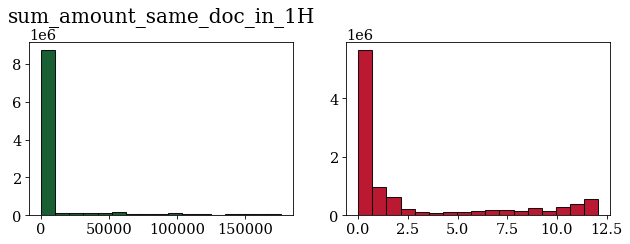

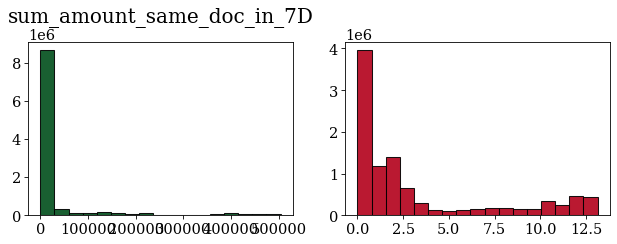

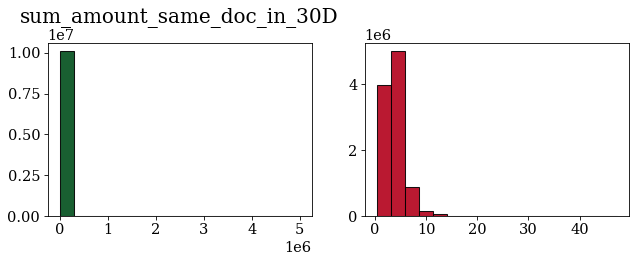

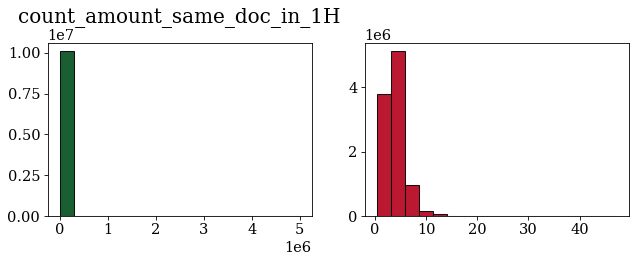

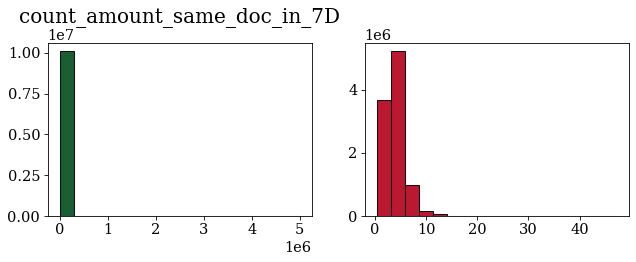

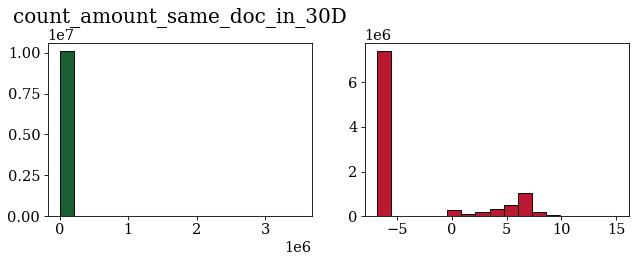

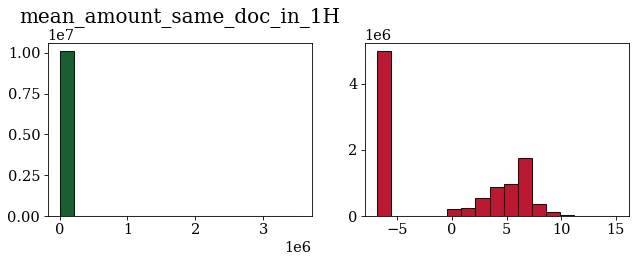

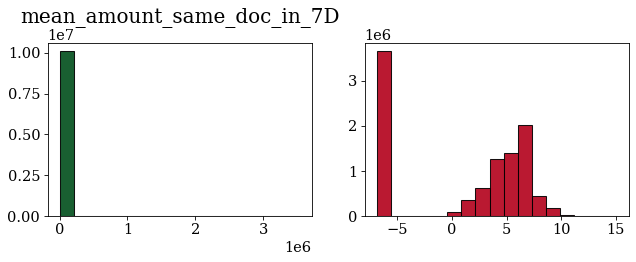

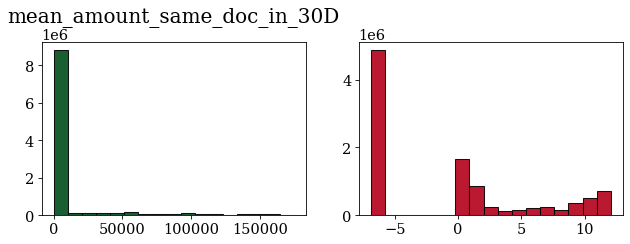

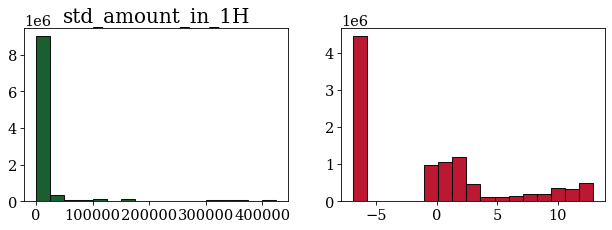

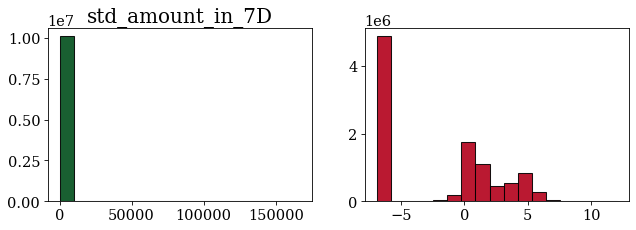

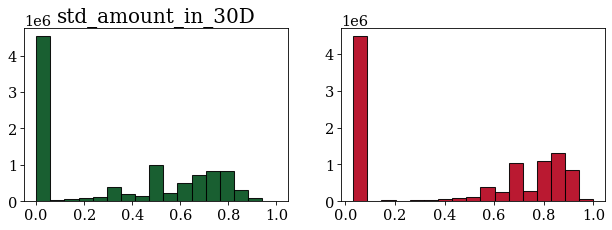

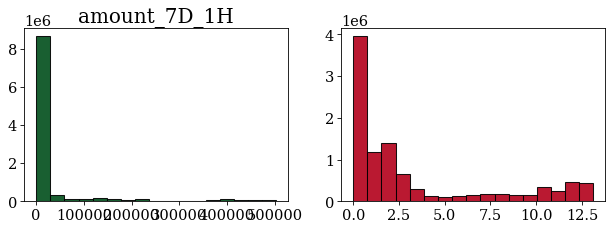

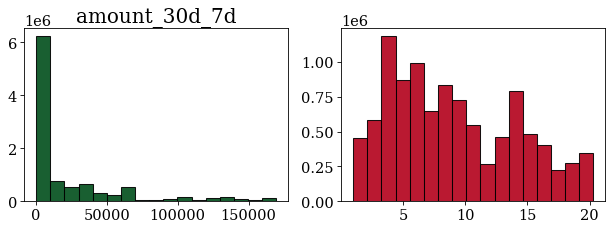

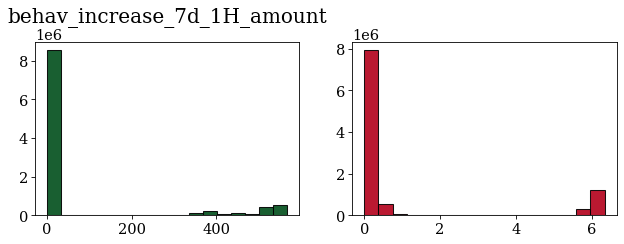

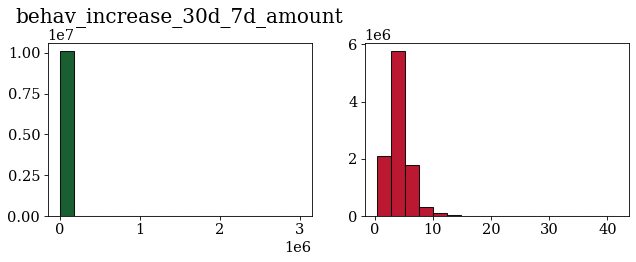

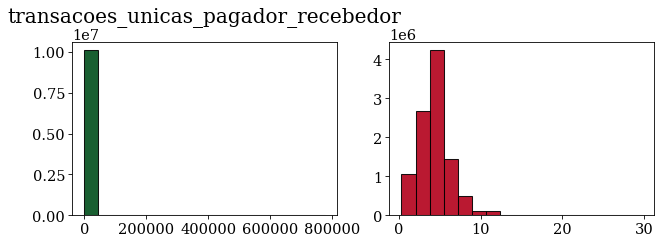

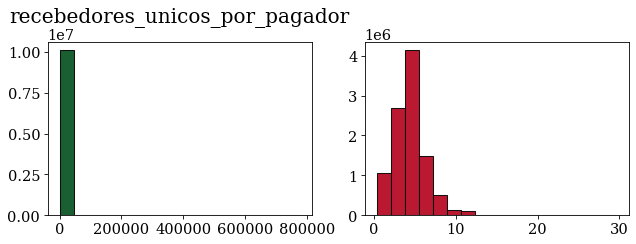

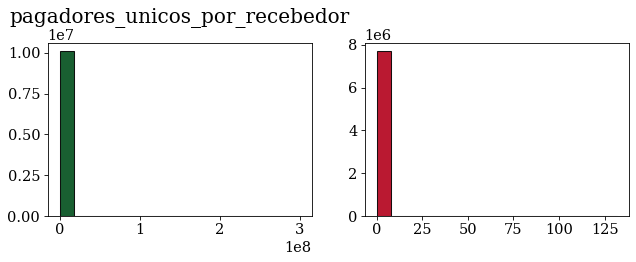

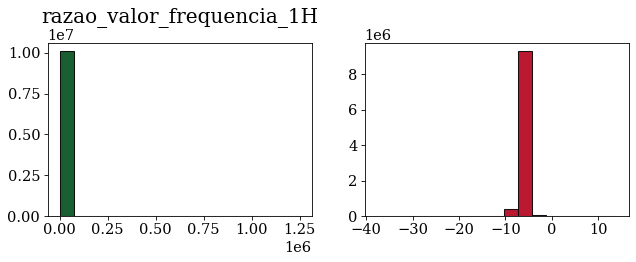

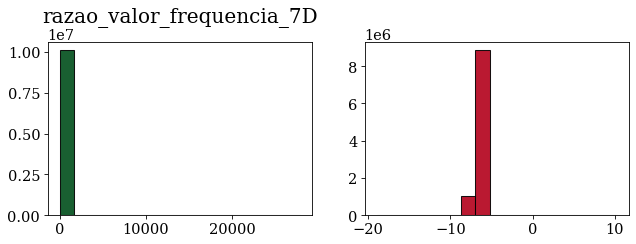

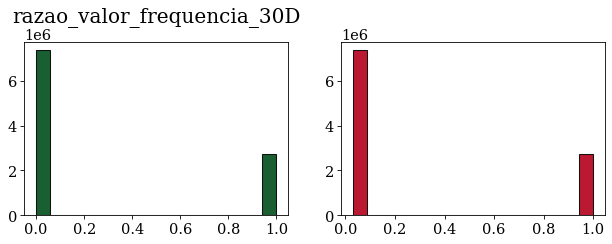

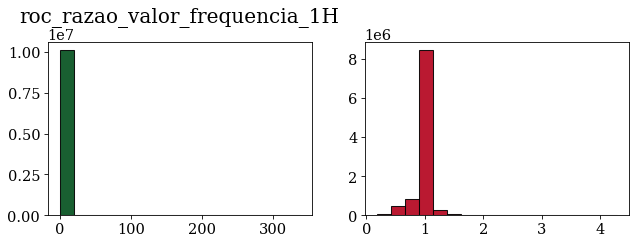

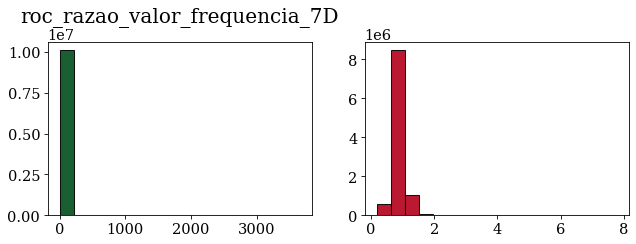

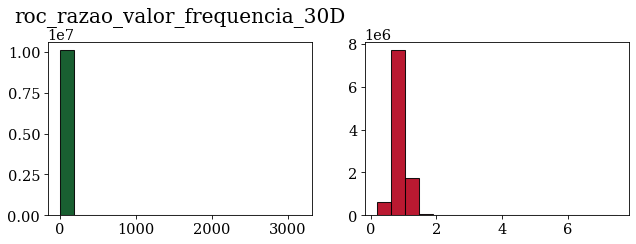

In [10]:
## Analise pora feature engineering log

for i in range(0, df.shape[1]):

    ## Histogramas
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.hist(df_raw.iloc[:, i], bins=17, edgecolor='black', color=[0,.3,.1], alpha=0.9);
    plt.title(numeric_features[i]);

    plt.subplot(1,2,2)
    plt.hist(df.iloc[:, i], bins=17, edgecolor='black', color=[.7,0,.1], alpha=0.9);
    # plt.title(f'{numeric_features[i]}');

In [11]:
## Adcionando a Variavel-Reposta
df['last_status'] = target
df['transaction_id'] = transaction_id
df['fraud'] = fraud


df['transaction_datetime_request'] = transaction_datetime_request
df['hora'] = hora
df['dia'] = dia
df['dia_semana'] = dia_semana

In [12]:
df['last_status'].value_counts()

last_status
APPROVED           10092900
REJECTED              17541
SUSPECTED_FRAUD         255
FRAUD                    49
CONT_FRAUD                3
Name: count, dtype: Int64

In [13]:
df['fraud'].value_counts()

fraud
0.00    10110699
1.00          49
Name: count, dtype: int64

In [14]:
df.head()

,transaction_amount_total,test_transaction,sum_amount_same_doc_in_1H,sum_amount_same_doc_in_7D,sum_amount_same_doc_in_30D,count_amount_same_doc_in_1H,count_amount_same_doc_in_7D,count_amount_same_doc_in_30D,mean_amount_same_doc_in_1H,mean_amount_same_doc_in_7D,mean_amount_same_doc_in_30D,std_amount_in_1H,std_amount_in_7D,std_amount_in_30D,amount_7D_1H,amount_30d_7d,behav_increase_7d_1H_amount,behav_increase_30d_7d_amount,transacoes_unicas_pagador_recebedor,recebedores_unicos_por_pagador,pagadores_unicos_por_recebedor,razao_valor_frequencia_1H,razao_valor_frequencia_7D,razao_valor_frequencia_30D,roc_razao_valor_frequencia_1H,roc_razao_valor_frequencia_7D,roc_razao_valor_frequencia_30D,flag_first_time_receiver,desvio_relativo_media_in_1H,desvio_relativo_media_in_7D,desvio_relativo_media_in_30D,last_status,transaction_id,fraud,transaction_datetime_request,hora,dia,dia_semana
0,0.91,0.00,0.91,0.91,0.91,0.00,0.00,0.00,1.26,1.26,1.26,-6.91,-6.91,-6.91,-6.91,-6.91,-6.91,0.03,0.00,1.00,0.00,1.26,1.26,1.26,0.18,-6.91,-6.91,1.00,1.00,1.00,1.00,APPROVED,e270840982024073017160rtzfasefw1,0.00,2024-05-01 03:00:28,3,1,2
1,4.79,0.00,4.79,4.79,4.79,0.00,0.00,0.00,3.31,3.31,3.31,-6.91,-6.91,-6.91,-6.91,-6.91,-6.91,0.03,0.00,1.19,0.00,2.80,2.80,2.80,2.21,3.16,3.16,1.00,1.00,1.00,1.00,APPROVED,1ef348c43d3c666982c4d5e473ee2e8e,0.00,2024-05-01 03:00:33,3,1,2
2,3.80,0.00,3.80,3.80,3.80,0.00,0.00,0.00,2.58,2.58,2.58,-6.91,-6.91,-6.91,-6.91,-6.91,-6.91,0.03,0.00,1.32,0.00,2.73,2.73,2.73,NaN,NaN,NaN,1.00,1.00,1.00,1.00,APPROVED,1ef348c5a64269349a2c3ae445f7e334,0.00,2024-05-01 03:00:56,3,1,2
3,4.61,0.00,4.61,4.61,4.61,0.00,0.00,0.00,3.16,3.16,3.16,-6.91,-6.91,-6.91,-6.91,-6.91,-6.91,0.03,0.00,1.41,0.00,2.86,2.86,2.86,0.67,-1.61,-1.61,1.00,1.00,1.00,1.00,APPROVED,1ef348c8edb6612b99b3bf80cf6755e5,0.00,2024-05-01 03:01:24,3,1,2
4,2.88,0.00,2.88,2.88,2.88,0.00,0.00,0.00,2.05,2.05,2.05,-6.91,-6.91,-6.91,-6.91,-6.91,-6.91,0.03,0.00,1.50,0.00,2.75,2.75,2.75,NaN,NaN,NaN,1.00,1.00,1.00,1.00,APPROVED,1ef348cac45867aa99b31c920525183a,0.00,2024-05-01 03:01:55,3,1,2


In [15]:
df['hora'].describe()

count   10110748.00
mean          14.40
std            6.25
min            0.00
25%           12.00
50%           16.00
75%           19.00
max           23.00
Name: hora, dtype: float64

In [16]:
df.to_parquet('dados/df_cashout_treino_sample_transformada.parquet')

In [17]:
from time import *
toc = time()
def convert_seconds(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

time_format = convert_seconds(toc-tic)

print(f'Tempo de Processamento: {time_format}')

Tempo de Processamento: 00:01:24
